In [4]:
import numpy as np
import pandas as pd
import fastplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import yscale
from numpy.lib.function_base import quantile
from pandas import value_counts
%matplotlib inline
import seaborn as sns
from adjustText import adjust_text
import json

In [5]:
sns.set_style("whitegrid") 
sns.set_context("paper")

# Packet Processing Time

In [8]:
# start from the 3rd line
raw_df = pd.read_csv("../log/log.log", header=None, skiprows=2, sep=",")
raw_df.head()

ParserError: Error tokenizing data. C error: Expected 4 fields in line 149, saw 6


In [179]:
stats_df = raw_df[raw_df['msg'] == 'stats']
stats_df.reset_index(inplace=True)

pkt_process_time_df = raw_df[raw_df['msg'] == 'pkt_processing_time'][['time', 'pkt_count', 'tcp_pkt_count_tot']]
pkt_process_time_df.columns = ['time', 'sample_at', 'pkt_process_time']
pkt_process_time_df.reset_index(inplace=True)
print(pkt_process_time_df.head())

timeout_df = raw_df[raw_df['msg'] == 'timeout'][['time', 'pkt_count']]
timeout_df.columns = ['time', 'timeout']
timeout_df.reset_index(inplace=True)
print(timeout_df.head())

   index      time  sample_at  pkt_process_time
0      0  0.000000       1000              42.0
1      1  0.007813       2000              10.0
2      2  0.013623       3000               9.0
3      3  0.019747       4000              16.0
4      4  0.025989       5000              33.0
   index      time  timeout
0     13  0.081505    27296
1     25  0.143609    24526
2     37  0.224837    29336
3     49  0.299164    22076
4     58  0.381148    27564


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

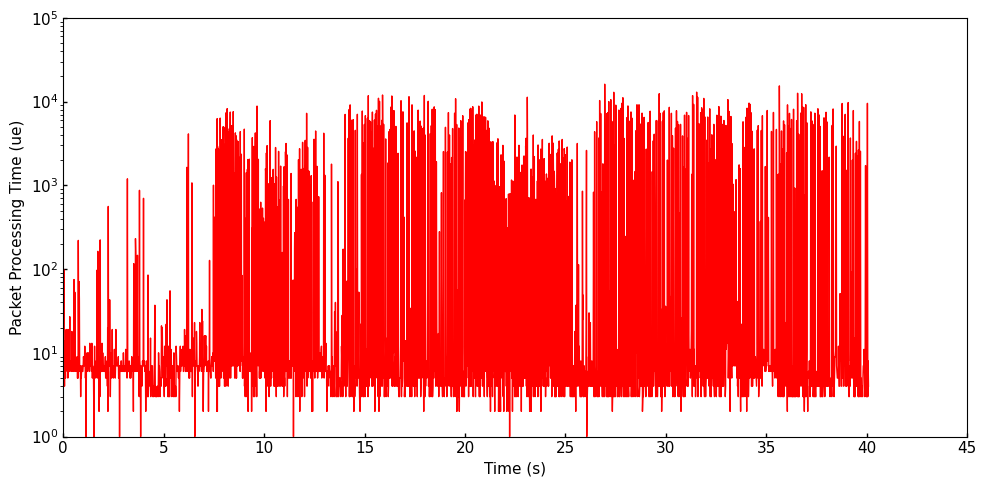

In [180]:
fastplot.plot((pkt_process_time_df['time'], pkt_process_time_df['pkt_process_time']), None, mode='line',
              yscale='log',
              figsize=(10, 5), xlabel='Time (s)', ylabel='Packet Processing Time (ue)')

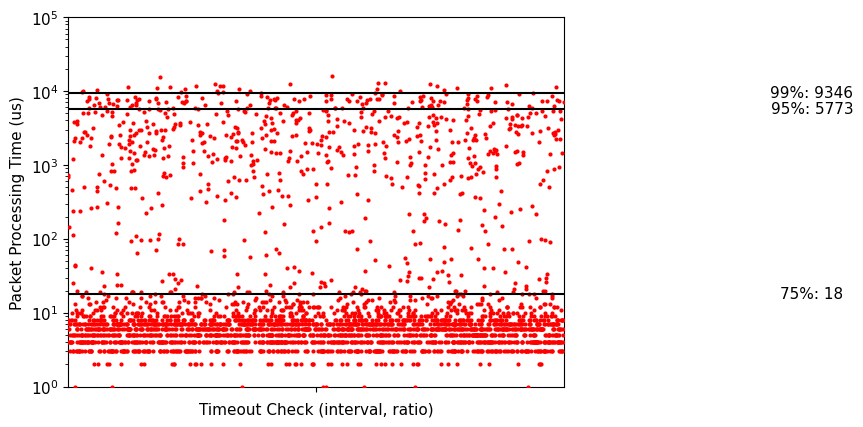

In [181]:
sns.stripplot(y='pkt_process_time', 
              size=3, legend=False,
              data=pkt_process_time_df, jitter=0.2)
plt.ylabel('Packet Processing Time (us)')
plt.xlabel('Timeout Check (interval, ratio)')
plt.yscale('log')

texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = pkt_process_time_df['pkt_process_time'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.4, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))

# adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)


# Timeout Bias (real buffered time (avg) - expected buffered time)

([Text(0.1628024193548387, 35132.66233766233, '75%: 35295'),
  Text(0.16265120967741936, 38445.09285714285, '95%: 39338'),
  Text(0.16265120967741936, 40488.931818181816, '99%: 39921')],
 [])

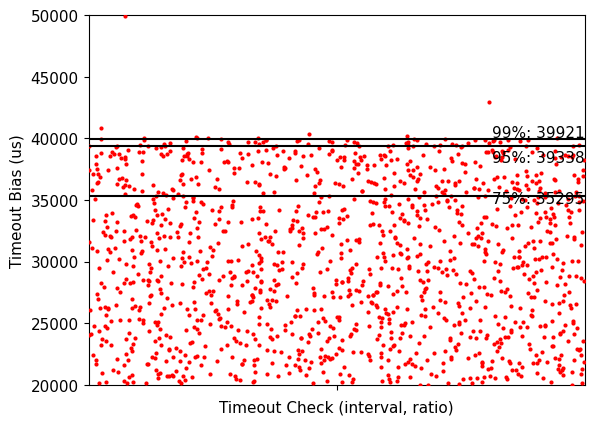

In [182]:
sns.stripplot(y='timeout', 
              size=3, legend=False,
              data=timeout_df, jitter=0.2)
plt.ylabel('Timeout Bias (us)')
plt.xlabel('Timeout Check (interval, ratio)')
# plt.yscale('log')

texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = timeout_df['timeout'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.4, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))
    
adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)

# Data Structure Usage

In [183]:
from cycler import cycler

mcolor_lists = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:green','tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'b', 'g', 'r', 'c', 'm', 'y', 'k',
                'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'rosybrown', 'tomato', 'yellowgreen', 'lightseagreen', 'navy', 'deeppink',
                'darkslategray', 'darkolivegreen', 'darkcyan', 'darkviolet', 'mediumslateblue', 'darkorange', 'gold', 'peru', 'darkkhaki']
CYCLER_LINES=(cycler('color', mcolor_lists[:30]) +
              cycler('linestyle', ['-', '--','-', '--','-', '--','-', '--', '-.', ':', (0, (10, 6)), (0, (6, 10)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)), (0, (3, 1, 1, 1)),
                                   '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 10)), (0,
                                                                                           (10, 6)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)),
                                   '-', '--', '-.', ':']))

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

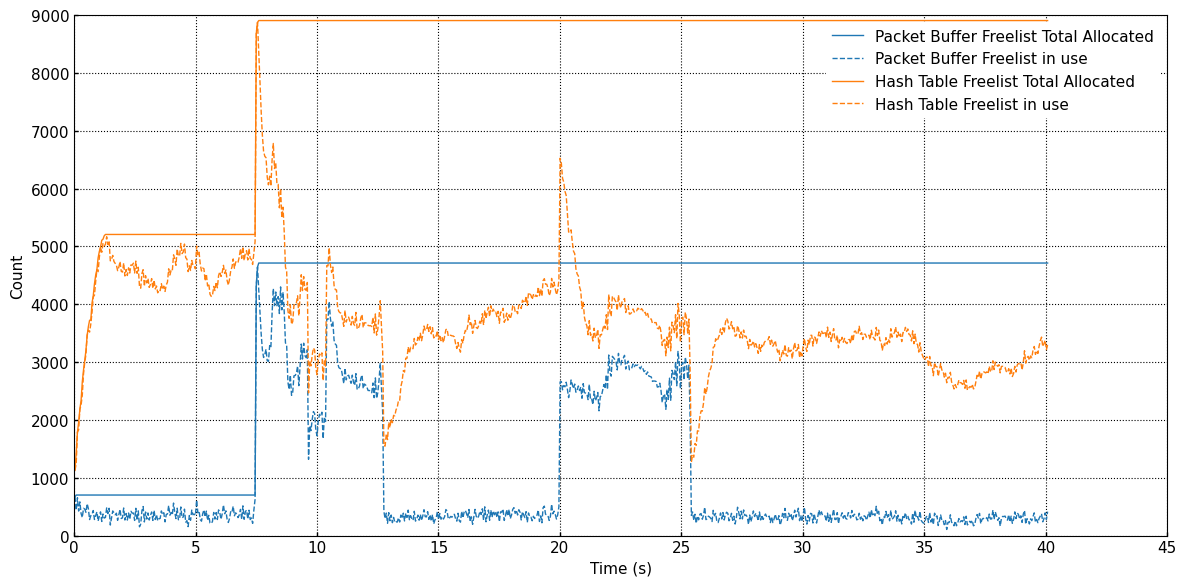

In [184]:
# buffered packet count

fastplot.plot([('Packet Buffer Freelist Total Allocated', (stats_df['time'], stats_df['pkt_list_count_tot'])),
              ('Packet Buffer Freelist in use', (stats_df['time'], stats_df['pkt_list_count_use'])),
               ('Hash Table Freelist Total Allocated', (stats_df['time'], stats_df['flow_hash_list_count_tot'])),
              ('Hash Table Freelist in use', (stats_df['time'], stats_df['flow_hash_list_count_use']))
              ],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(12, 6), grid=True,
              # xlim=(stats_df['time'].min(), stats_df['time'].min() + pd.Timedelta('5 seconds')),
              # yscale='log', ylim=(10**3, 10**4),
              cycler=CYCLER_LINES,
              xlabel='Time (s)', 
              ylabel='Count')


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

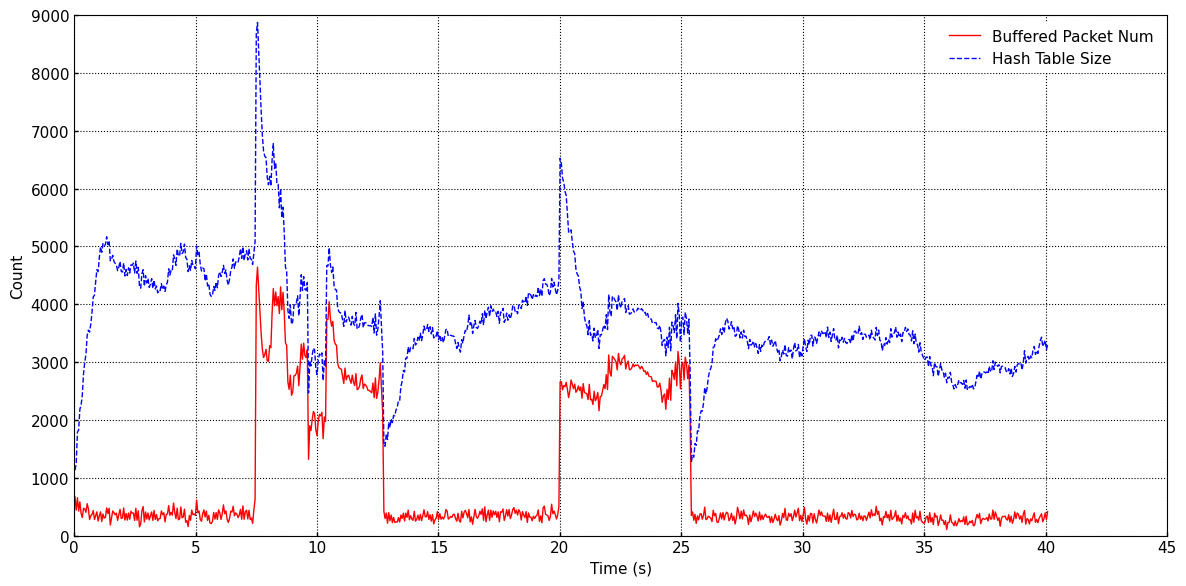

In [185]:
# buffered packet count

fastplot.plot([('Buffered Packet Num', (stats_df['time'], stats_df['pkt_buf_count'])),
              ('Hash Table Size', (stats_df['time'], stats_df['flow_hash_count']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(12, 6), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')


<Axes: >

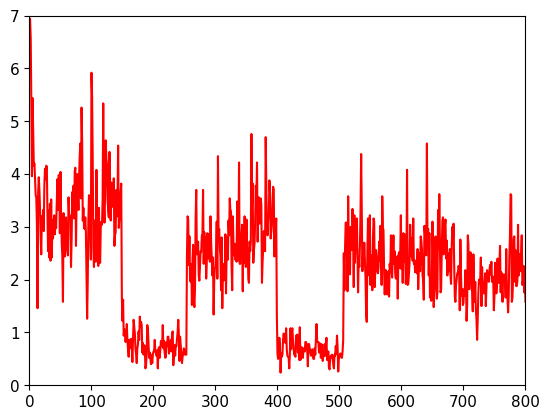

In [186]:
stats_df['replied_flow_count_tot'].diff()[1:].apply(lambda x: x/50).plot()

<Axes: >

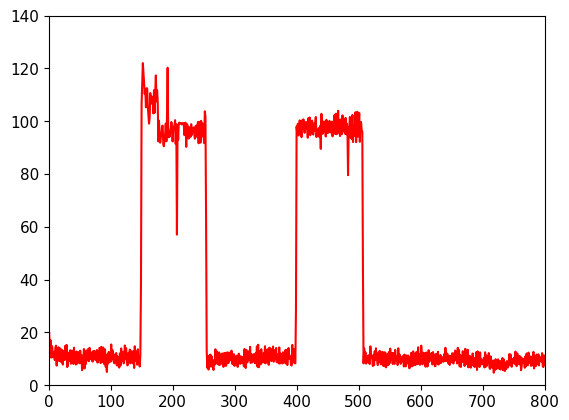

In [192]:
stats_df['expired_pkt_count_tot'].diff()[1:].apply(lambda x: x/50).plot()

# Data Plane Resource Usage

## Table Entry Count

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

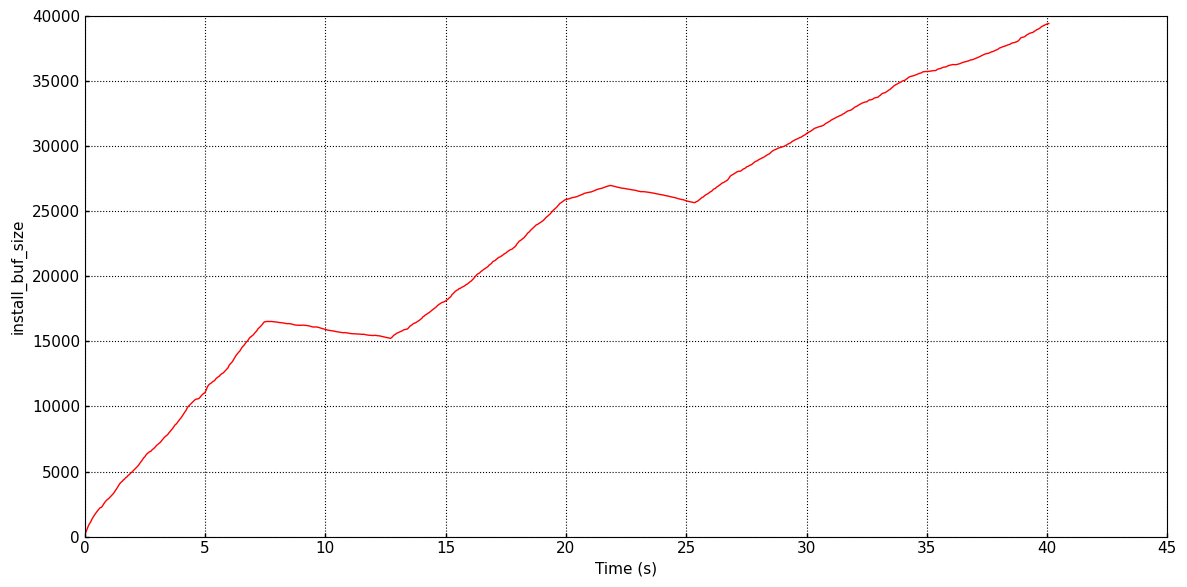

In [188]:
fastplot.plot((stats_df['time'], stats_df['install_buf_size']),
                None,
                mode='line',
                legend_loc='best',
                figsize=(12, 6), grid=True,
                xlabel='Time (s)', 
                ylabel='install_buf_size')

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

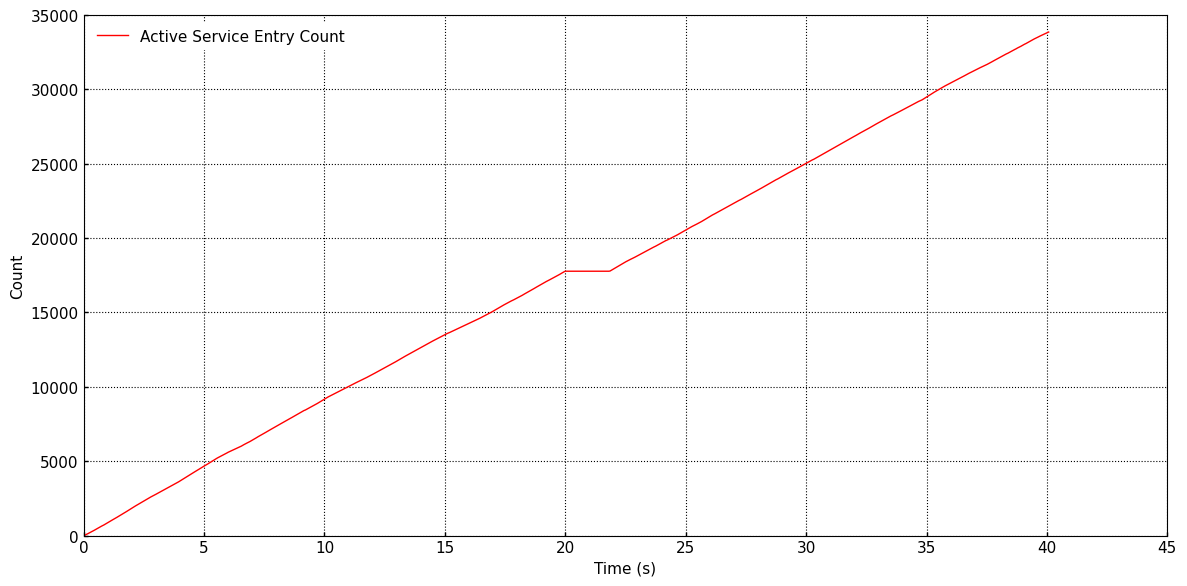

In [189]:

fastplot.plot([('Active Service Entry Count', (stats_df['time'], stats_df['active_host_tbl_entry_count']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(12, 6), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')

# Network Speed Statistic

In [190]:
net_speed_df = []

with open('../log/speed_log.json', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'jsonversion' not in line and 'maxratestring' not in line:
            line = json.loads(line)
            net_speed_df.append({'time': line['seconds'], 'rx_speed': line['rx']['ratestring']})

net_speed_df = pd.DataFrame(net_speed_df)
net_speed_df['rx_speed'] = net_speed_df['rx_speed'].apply(lambda x: x.replace(' bit/s', 'e-9').replace(' kbit/s', 'e-6').replace(' Mbit/s', 'e-3').replace(' Gbit/s', ''))
net_speed_df['rx_speed'] = net_speed_df['rx_speed'].astype(float)
net_speed_df.head()

,time,rx_speed
0,2,0.0
1,4,0.0
2,6,0.0
3,8,0.0
4,10,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

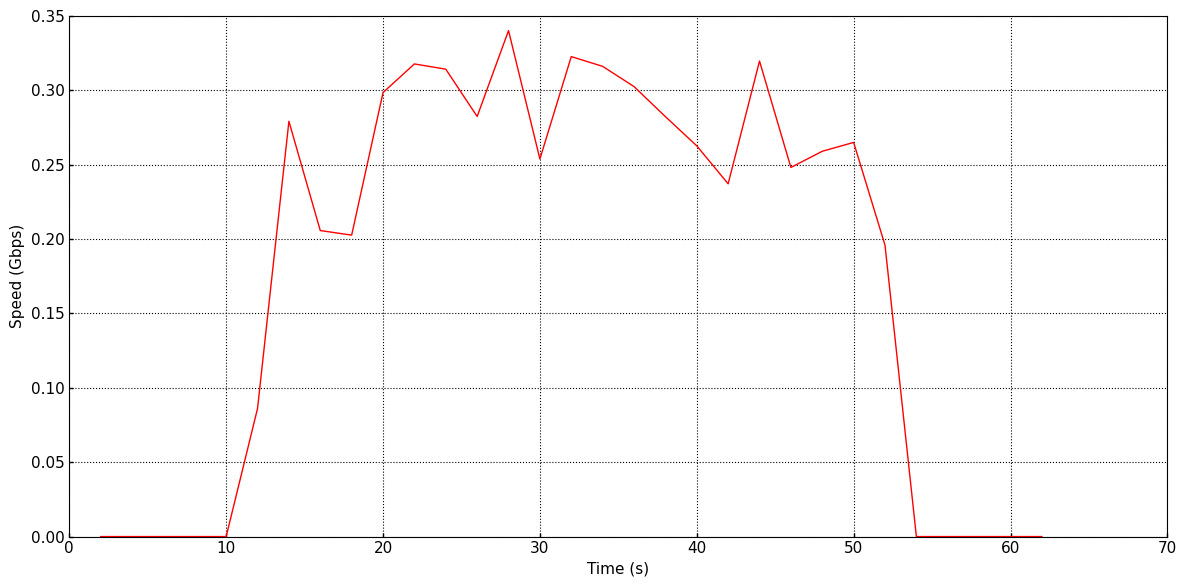

In [191]:
fastplot.plot((net_speed_df['time'], net_speed_df['rx_speed']),
                None,
                mode='line',
                legend=True, legend_loc='best',
                figsize=(12, 6), grid=True,
                xlabel='Time (s)', 
                ylabel='Speed (Gbps)')